# Configuration

In [1]:
#!pip install tensorflow-addons

In [2]:
class CFG:
    aggregation_data_path = "../input/isolated-sign-language-aggregation-dataset/"
    data_path = "../input/asl-signs/"
    pred_model = '../input/sign-language-prediction-model/'
    make_featuregen = False
    quick_experiment = False
    kfold_training = False
    DROP_Z = False
    is_training = False
    make_aggregation_dataset = False
    num_classes = 250
    rows_per_frame = 543 

# Import Packages

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm
import json
import os
import gc
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedGroupKFold
from types import SimpleNamespace
from types import SimpleNamespace
from pathlib import Path
import math
import scipy
import matplotlib.pyplot as plt


#LANDMARK_IDX = [0,9,11,13,14,17,117,118,119,199,346,347,348] + list(range(468,543))

# Utilities

In [4]:
def load_relevant_data_subset_with_imputation(pq_path):
    data_columns = ['landmark_index','x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    data['landmark_index'] = list(range(0,543))*int(len(data) / CFG.rows_per_frame)
    data.replace(np.nan, 0, inplace=True)
    data.drop(data[~data['landmark_index'].isin(LANDMARK_IDX)].index, inplace=True)
    data = data.drop('landmark_index', axis=1)
    n_frames = int(len(data) / len(LANDMARK_IDX))
    data = data.values.reshape(n_frames, len(LANDMARK_IDX), 3)
    return data.astype(np.float32)

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / CFG.rows_per_frame)
    data = data.values.reshape(n_frames, CFG.rows_per_frame, len(data_columns))
    return data.astype(np.float32)

def read_dict(file_path):
    path = os.path.expanduser(file_path)
    with open(path, "r") as f:
        dic = json.load(f)
    return dic

# Load data

In [5]:
train = pd.read_csv(f"{CFG.aggregation_data_path}train.csv")
train.head()

,path,participant_id,sequence_id,sign,label,num_frames
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,25,23.0
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,232,11.0
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,48,105.0
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,23,12.0
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,164,18.0


There are 21 participants. Each of them create about 3000 to 5000 training records.

In [6]:
train.participant_id.nunique()

21

<AxesSubplot:>

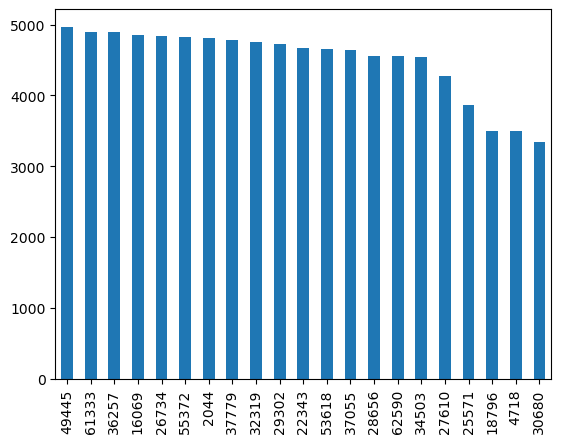

In [7]:
train.participant_id.value_counts().plot(kind="bar")

There are 94477 training samples in total.

There are 250 kinds of sign languages that we need to make prediction on. Each kind of sign languages contains about 300 to 400 samples.

In [8]:
label_index = read_dict(f"{CFG.data_path}sign_to_prediction_index_map.json")
index_label = dict([(label_index[key], key) for key in label_index])
print(label_index)
train["label"] = train["sign"].map(lambda sign: label_index[sign])
train.head()

{'TV': 0, 'after': 1, 'airplane': 2, 'all': 3, 'alligator': 4, 'animal': 5, 'another': 6, 'any': 7, 'apple': 8, 'arm': 9, 'aunt': 10, 'awake': 11, 'backyard': 12, 'bad': 13, 'balloon': 14, 'bath': 15, 'because': 16, 'bed': 17, 'bedroom': 18, 'bee': 19, 'before': 20, 'beside': 21, 'better': 22, 'bird': 23, 'black': 24, 'blow': 25, 'blue': 26, 'boat': 27, 'book': 28, 'boy': 29, 'brother': 30, 'brown': 31, 'bug': 32, 'bye': 33, 'callonphone': 34, 'can': 35, 'car': 36, 'carrot': 37, 'cat': 38, 'cereal': 39, 'chair': 40, 'cheek': 41, 'child': 42, 'chin': 43, 'chocolate': 44, 'clean': 45, 'close': 46, 'closet': 47, 'cloud': 48, 'clown': 49, 'cow': 50, 'cowboy': 51, 'cry': 52, 'cut': 53, 'cute': 54, 'dad': 55, 'dance': 56, 'dirty': 57, 'dog': 58, 'doll': 59, 'donkey': 60, 'down': 61, 'drawer': 62, 'drink': 63, 'drop': 64, 'dry': 65, 'dryer': 66, 'duck': 67, 'ear': 68, 'elephant': 69, 'empty': 70, 'every': 71, 'eye': 72, 'face': 73, 'fall': 74, 'farm': 75, 'fast': 76, 'feet': 77, 'find': 78, '

,path,participant_id,sequence_id,sign,label,num_frames
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,25,23.0
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,232,11.0
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,48,105.0
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,23,12.0
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,164,18.0


In [9]:
train["sign"].value_counts()

listen    415
look      414
shhh      411
donkey    410
mouse     408
         ... 
dance     312
person    312
beside    310
vacuum    307
zipper    299
Name: sign, Length: 250, dtype: int64

Here are descriptive statistics for number of frames.

In [10]:
train.num_frames.describe()

count    94477.000000
mean        37.935021
std         44.177069
min          2.000000
25%         12.000000
50%         22.000000
75%         44.000000
max        537.000000
Name: num_frames, dtype: float64

In [11]:
# if CFG.make_aggregation_dataset:
#     xs = []
#     ys = []
#     num_frames = np.zeros(len(train))
#     for i in tqdm(range(len(train))):
#         path = f"{CFG.data_path}{train.iloc[i].path}"
#         data = load_relevant_data_subset_with_imputation(path)
#         ## Mean Aggregation
#         xs.append(np.mean(data, axis=0))
#         ys.append(train.iloc[i].label)
#         num_frames[i] = data.shape[0]
#         if CFG.quick_experiment and i == 4999:
#             break
#     ## Save number of frames of each training sample for data analysis
#     train["num_frames"] = num_frames
#     X = np.array(xs)
#     y = np.array(ys)
#     print(train["num_frames"].describe())
#     train.to_csv("train.csv", index=False)
# else:
#     X = np.load("X_dropped.npy")
#     y = np.load("y_dropped.npy")
# print(X.shape, y.shape)

# Transformer

## Configuration

In [12]:
cfg = SimpleNamespace()

In [13]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [14]:
DATA_DIR         = Path('../data/') if not iskaggle else Path('/kaggle/input/asl-signs/')
TRAIN_CSV_PATH   = DATA_DIR/'train.csv'
LANDMARK_DIR     = DATA_DIR/'train_landmark_files'
LABEL_MAP_PATH   = DATA_DIR/'sign_to_prediction_index_map.json'

In [15]:
cfg.PREPROCESS_DATA = False
cfg.TRAIN_MODEL = False
cfg.N_ROWS = 543
cfg.N_DIMS = 3
cfg.DIM_NAMES = ['x', 'y', 'z']
cfg.SEED = 42
cfg.NUM_CLASSES = 250
cfg.IS_INTERACTIVE = True
cfg.VERBOSE = 2
cfg.INPUT_SIZE = 32
cfg.BATCH_ALL_SIGNS_N = 4
cfg.BATCH_SIZE = 256
cfg.N_EPOCHS = 100
cfg.LR_MAX = 1e-3
cfg.N_WARMUP_EPOCHS = 0
cfg.WD_RATIO = 0.05
cfg.MASK_VAL = 4237

In [16]:
train = pd.read_csv(TRAIN_CSV_PATH)
N_SAMPLES = len(train)

In [17]:
# Get complete file path to file
def get_file_path(path):
    return f'/kaggle/input/asl-signs/{path}'

!ln -s {LANDMARK_DIR} ./train_landmark_files
train['file_path'] = train['path'].values
train.head(2)

,path,participant_id,sequence_id,sign,file_path
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,train_landmark_files/26734/1000035562.parquet
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,train_landmark_files/28656/1000106739.parquet


In [18]:
train['sign_ord'] = train['sign'].astype('category').cat.codes
SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

In [19]:
N_PARTICIPANTS = train.participant_id.nunique()
sgkf = StratifiedGroupKFold(n_splits=7, shuffle=True, random_state=43)
train['fold'] = -1
for i, (train_idx, val_idx) in enumerate(sgkf.split(train.index, train.sign, train.participant_id)):
    train.loc[val_idx, 'fold'] = i
train.head(2)

,path,participant_id,sequence_id,sign,file_path,sign_ord,fold
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,train_landmark_files/26734/1000035562.parquet,25,0
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,train_landmark_files/28656/1000106739.parquet,232,2


In [20]:
# create indexes using fold `0` for now
train_idxs = train.query("fold!=0").index.values
val_idxs = train.query("fold==0").index.values

In [21]:
len(train_idxs), len(val_idxs)

(81735, 12742)

## Preprocessing

In [22]:
# landmark indices in original data
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])
LEFT_HAND_IDXS0  = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
POSE_IDXS0       = np.arange(502, 512)
LANDMARK_IDXS0   = np.concatenate((LIPS_IDXS0, LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0, POSE_IDXS0))
HAND_IDXS0       = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)
N_COLS           = LANDMARK_IDXS0.size
N_COLS, LANDMARK_IDXS0

(92,
 array([ 61, 185,  40,  39,  37,   0, 267, 269, 270, 409, 291, 146,  91,
        181,  84,  17, 314, 405, 321, 375,  78, 191,  80,  81,  82,  13,
        312, 311, 310, 415,  95,  88, 178,  87,  14, 317, 402, 318, 324,
        308, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479,
        480, 481, 482, 483, 484, 485, 486, 487, 488, 522, 523, 524, 525,
        526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538,
        539, 540, 541, 542, 502, 503, 504, 505, 506, 507, 508, 509, 510,
        511]))

In [23]:
# Landmark indices in processed data
LIPS_IDXS       = np.argwhere(np.isin(LANDMARK_IDXS0, LIPS_IDXS0)).squeeze()
LEFT_HAND_IDXS  = np.argwhere(np.isin(LANDMARK_IDXS0, LEFT_HAND_IDXS0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS0, RIGHT_HAND_IDXS0)).squeeze()
HAND_IDXS       = np.argwhere(np.isin(LANDMARK_IDXS0, HAND_IDXS0)).squeeze()
POSE_IDXS       = np.argwhere(np.isin(LANDMARK_IDXS0, POSE_IDXS0)).squeeze()
print(HAND_IDXS.shape)

(42,)


In [24]:
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        
    def pad_edge(self, t, repeats, side):
        if side == 'LEFT':
            return tf.concat((tf.repeat(t[:1], repeats=repeats, axis=0), t), axis=0)
        elif side == 'RIGHT':
            return tf.concat((t, tf.repeat(t[-1:], repeats=repeats, axis=0)), axis=0)
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,cfg.N_ROWS,cfg.N_DIMS], dtype=tf.float32),),
    )
    def call(self, data0):
        # Number of Frames in Video
        N_FRAMES0 = tf.shape(data0)[0]
        
        # Keep only non-empty frames in data
        frames_hands_nansum = tf.experimental.numpy.nanmean(tf.gather(data0, HAND_IDXS0, axis=1), axis=[1,2])
        non_empty_frames_idxs = tf.where(frames_hands_nansum > 0)
        non_empty_frames_idxs = tf.squeeze(non_empty_frames_idxs, axis=1)
        data = tf.gather(data0, non_empty_frames_idxs, axis=0)
        
        non_empty_frames_idxs = tf.cast(non_empty_frames_idxs, tf.float32) 
        
        # Number of non-empty frames
        N_FRAMES = tf.shape(data)[0]
        data = tf.gather(data, LANDMARK_IDXS0, axis=1)
        
        if N_FRAMES < cfg.INPUT_SIZE:
            # Video fits in cfg.INPUT_SIZE
            non_empty_frames_idxs = tf.pad(non_empty_frames_idxs, [[0, cfg.INPUT_SIZE-N_FRAMES]], constant_values=-1)
            data = tf.pad(data, [[0, cfg.INPUT_SIZE-N_FRAMES], [0,0], [0,0]], constant_values=0)
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            return data, non_empty_frames_idxs
        else:
            # Video needs to be downsampled to cfg.INPUT_SIZE
            if N_FRAMES < cfg.INPUT_SIZE**2:
                repeats = tf.math.floordiv(cfg.INPUT_SIZE * cfg.INPUT_SIZE, N_FRAMES0)
                data = tf.repeat(data, repeats=repeats, axis=0)
                non_empty_frames_idxs = tf.repeat(non_empty_frames_idxs, repeats=repeats, axis=0)
            
            # Pad To Multiple Of Input Size
            pool_size = tf.math.floordiv(len(data), cfg.INPUT_SIZE)
            if tf.math.mod(len(data), cfg.INPUT_SIZE) > 0:
                pool_size += 1
            if pool_size == 1:
                pad_size = (pool_size * cfg.INPUT_SIZE) - len(data)
            else:
                pad_size = (pool_size * cfg.INPUT_SIZE) % len(data)

            # Pad Start/End with Start/End value
            pad_left = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(cfg.INPUT_SIZE, 2)
            pad_right = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(cfg.INPUT_SIZE, 2)
            if tf.math.mod(pad_size, 2) > 0:
                pad_right += 1

            # Pad By Concatenating Left/Right Edge Values
            data = self.pad_edge(data, pad_left, 'LEFT')
            data = self.pad_edge(data, pad_right, 'RIGHT')

            # Pad Non Empty Frame Indices
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_left, 'LEFT')
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_right, 'RIGHT')

            # Reshape to Mean Pool
            data = tf.reshape(data, [cfg.INPUT_SIZE, -1, N_COLS, cfg.N_DIMS])
            non_empty_frames_idxs = tf.reshape(non_empty_frames_idxs, [cfg.INPUT_SIZE, -1])

            # Mean Pool
            data = tf.experimental.numpy.nanmean(data, axis=1)
            non_empty_frames_idxs = tf.experimental.numpy.nanmean(non_empty_frames_idxs, axis=1)

            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            
            return data, non_empty_frames_idxs
    
preprocess_layer = PreprocessLayer()

In [25]:
sample = load_relevant_data_subset(train.path[0])
sample.shape

(23, 543, 3)

In [26]:
data, non_empty_frames_idxs = preprocess_layer(sample)
data.shape, non_empty_frames_idxs

(TensorShape([32, 92, 3]),
 <tf.Tensor: shape=(32,), dtype=float32, numpy=
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 22., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1.], dtype=float32)>)

In [27]:
# free up RAM, delete variables as we go
del data; del non_empty_frames_idxs

## Create Dataset

In [28]:
LIPS_START = 0
LEFT_HAND_START = LIPS_IDXS.size
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

In [29]:
def get_data(file_path):
    data = load_relevant_data_subset(file_path)
    data = preprocess_layer(data)
    return data

In [30]:
def get_x_y():
    # Create arrays to save data
    X = np.zeros([N_SAMPLES, cfg.INPUT_SIZE, N_COLS, cfg.N_DIMS], dtype=np.float32)
    y = np.zeros([N_SAMPLES], dtype=np.int32)
    NON_EMPTY_FRAME_IDXS = np.full([N_SAMPLES, cfg.INPUT_SIZE], -1, dtype=np.float32)
    print(NON_EMPTY_FRAME_IDXS)

    for row_idx, (file_path, sign_ord) in enumerate(tqdm(train[['file_path', 'sign_ord']].values)):
        if row_idx % 5000 == 0:
            print(f'Generated {row_idx}/{N_SAMPLES}')

        data, non_empty_frame_idxs = get_data(file_path)
        X[row_idx] = data
        y[row_idx] = sign_ord
        NON_EMPTY_FRAME_IDXS[row_idx] = non_empty_frame_idxs
        if np.isnan(data).sum() > 0: return data

    # Save X/y
    np.save('X.npy', X)
    np.save('y.npy', y)
    np.save('NON_EMPTY_FRAME_IDXS.npy', NON_EMPTY_FRAME_IDXS)
    return X, y, NON_EMPTY_FRAME_IDXS

In [31]:
if cfg.PREPROCESS_DATA:
    X, y, NON_EMPTY_FRAME_IDXS = get_x_y()
else:
    X = np.load('/kaggle/input/islr-feature-gen-dataset/X.npy')
    y = np.load('/kaggle/input/islr-feature-gen-dataset/y.npy')
    NON_EMPTY_FRAME_IDXS = np.load('/kaggle/input/islr-feature-gen-dataset/NON_EMPTY_FRAME_IDXS.npy')

In [32]:
X.shape, y.shape, NON_EMPTY_FRAME_IDXS.shape

((94477, 32, 92, 3), (94477,), (94477, 32))

## Feature Statistics

In [33]:
# LIPS
LIPS_MEAN_X  = np.zeros([LIPS_IDXS.size], dtype=np.float32)
LIPS_MEAN_Y  = np.zeros([LIPS_IDXS.size], dtype=np.float32)
LIPS_STD_X   = np.zeros([LIPS_IDXS.size], dtype=np.float32)
LIPS_STD_Y   = np.zeros([LIPS_IDXS.size], dtype=np.float32)
for col, ll in enumerate(tqdm( np.transpose(X[:,:,LIPS_IDXS], [2,3,0,1]).reshape([LIPS_IDXS.size, cfg.N_DIMS, -1]) )):
    for dim, l in enumerate(ll):
        #print(dim, len(l))
        v = l[np.nonzero(l)]
        if dim == 0: # X
            LIPS_MEAN_X[col] = v.mean()
            LIPS_STD_X[col] = v.std()
        if dim == 1: # Y
            LIPS_MEAN_Y[col] = v.mean()
            LIPS_STD_Y[col] = v.std()
        
LIPS_MEAN = np.array([LIPS_MEAN_X, LIPS_MEAN_Y]).T
LIPS_STD = np.array([LIPS_STD_X, LIPS_STD_Y]).T

  0%|          | 0/40 [00:00<?, ?it/s]

In [34]:
# LEFT HAND
LEFT_HANDS_MEAN_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
LEFT_HANDS_MEAN_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
LEFT_HANDS_STD_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
LEFT_HANDS_STD_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
# RIGHT HAND
RIGHT_HANDS_MEAN_X = np.zeros([RIGHT_HAND_IDXS.size], dtype=np.float32)
RIGHT_HANDS_MEAN_Y = np.zeros([RIGHT_HAND_IDXS.size], dtype=np.float32)
RIGHT_HANDS_STD_X = np.zeros([RIGHT_HAND_IDXS.size], dtype=np.float32)
RIGHT_HANDS_STD_Y = np.zeros([RIGHT_HAND_IDXS.size], dtype=np.float32)

for col, ll in enumerate(tqdm( np.transpose(X[:,:,HAND_IDXS], [2,3,0,1]).reshape([HAND_IDXS.size, cfg.N_DIMS, -1]))):
    for dim, l in enumerate(ll):
        v = l[np.nonzero(l)]
        if dim == 0: # X
            if col < RIGHT_HAND_IDXS.size: # LEFT HAND
                LEFT_HANDS_MEAN_X[col] = v.mean()
                LEFT_HANDS_STD_X[col] = v.std()
            else:
                RIGHT_HANDS_MEAN_X[col - LEFT_HAND_IDXS.size] = v.mean()
                RIGHT_HANDS_STD_X[col - LEFT_HAND_IDXS.size] = v.std()
        if dim == 1: # Y
            if col < RIGHT_HAND_IDXS.size: # LEFT HAND
                LEFT_HANDS_MEAN_Y[col] = v.mean()
                LEFT_HANDS_STD_Y[col] = v.std()
            else: # RIGHT HAND
                RIGHT_HANDS_MEAN_Y[col - LEFT_HAND_IDXS.size] = v.mean()
                RIGHT_HANDS_STD_Y[col - LEFT_HAND_IDXS.size] = v.std()
        
LEFT_HANDS_MEAN = np.array([LEFT_HANDS_MEAN_X, LEFT_HANDS_MEAN_Y]).T
LEFT_HANDS_STD = np.array([LEFT_HANDS_STD_X, LEFT_HANDS_STD_Y]).T
RIGHT_HANDS_MEAN = np.array([RIGHT_HANDS_MEAN_X, RIGHT_HANDS_MEAN_Y]).T
RIGHT_HANDS_STD = np.array([RIGHT_HANDS_STD_X, RIGHT_HANDS_STD_Y]).T

  0%|          | 0/42 [00:00<?, ?it/s]

In [35]:
# POSE
POSE_MEAN_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
POSE_MEAN_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)
POSE_STD_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
POSE_STD_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)

for col, ll in enumerate(tqdm( np.transpose(X[:,:,POSE_IDXS], [2,3,0,1]).reshape([POSE_IDXS.size, cfg.N_DIMS, -1]) )):
    for dim, l in enumerate(ll):
        v = l[np.nonzero(l)]
        if dim == 0: # X
            POSE_MEAN_X[col] = v.mean()
            POSE_STD_X[col] = v.std()
        if dim == 1: # Y
            POSE_MEAN_Y[col] = v.mean()
            POSE_STD_Y[col] = v.std()
        
POSE_MEAN = np.array([POSE_MEAN_X, POSE_MEAN_Y]).T
POSE_STD = np.array([POSE_STD_X, POSE_STD_Y]).T

  0%|          | 0/10 [00:00<?, ?it/s]

In [36]:
# Custom sampler to get a batch containing N times all signs
def get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS, n=cfg.BATCH_ALL_SIGNS_N):
    # Arrays to store batch in
    X_batch = np.zeros([cfg.NUM_CLASSES*n, cfg.INPUT_SIZE, N_COLS, cfg.N_DIMS], dtype=np.float32)
    y_batch = np.arange(0, cfg.NUM_CLASSES, step=1/n, dtype=np.float32).astype(np.int64)
    non_empty_frame_idxs_batch = np.zeros([cfg.NUM_CLASSES*n, cfg.INPUT_SIZE], dtype=np.float32)
    
    # Dictionary mapping ordinally encoded sign to corresponding sample indices
    CLASS2IDXS = {}
    for i in range(cfg.NUM_CLASSES):
        CLASS2IDXS[i] = np.argwhere(y == i).squeeze().astype(np.int32)
            
    while True:
        # Fill batch arrays
        for i in range(cfg.NUM_CLASSES):
            idxs = np.random.choice(CLASS2IDXS[i], n)
            X_batch[i*n:(i+1)*n] = X[idxs]
            non_empty_frame_idxs_batch[i*n:(i+1)*n] = NON_EMPTY_FRAME_IDXS[idxs]
        
        yield { 'frames': X_batch, 'non_empty_frame_idxs': non_empty_frame_idxs_batch }, y_batch

In [37]:
dummy_dataset = get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS)
X_batch, y_batch = next(dummy_dataset)
#print(X_batch)
X_batch.keys(), X_batch['frames'].shape

(dict_keys(['frames', 'non_empty_frame_idxs']), (1000, 32, 92, 3))

## Model config

In [38]:
# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# Dense layer units for landmarks
LIPS_UNITS = 384
HANDS_UNITS = 384
POSE_UNITS = 384
# final embedding and transformer embedding size
UNITS = 384

# Transformer
NUM_BLOCKS = 2
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu

In [39]:
# based on: https://stackoverflow.com/questions/67342988/verifying-the-implementation-of-multihead-attention-in-transformer
# replaced softmax with softmax layer to support masked softmax
def scaled_dot_product(q,k,v, softmax, attention_mask):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True)
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt, mask=attention_mask)
    
    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_of_heads):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model//num_of_heads
        self.wq = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()
        
    def call(self,x, attention_mask):
        
        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax, attention_mask))
            
        multi_head = tf.concat(multi_attn,axis=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention

In [40]:
class Transformer(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Transformer, self).__init__(name='transformer')
        self.num_blocks = num_blocks
    
    def build(self, input_shape):
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # First Layer Normalisation
            self.ln_1s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS, 12))
            # Second Layer Normalisation
            self.ln_2s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS, kernel_initializer=INIT_HE_UNIFORM),
            ]))
        
    def call(self, x, attention_mask):
        # Iterate input over transformer blocks
        for ln_1, mha, ln_2, mlp in zip(self.ln_1s, self.mhas, self.ln_2s, self.mlps):
            x1 = ln_1(x)
            attention_output = mha(x1, attention_mask)
            x2 = x1 + attention_output
            x3 = ln_2(x2)
            x3 = mlp(x3)
            x = x3 + x2
    
        return x

In [41]:
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units
        
    def build(self, input_shape):
        # Embedding for missing landmark in frame, initizlied with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        # Embedding
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM, activation=GELU),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

## Embedding

In [42]:
class CustomEmbedding(tf.keras.Model):
    def __init__(self):
        super(CustomEmbedding, self).__init__()
        
    def get_diffs(self, l):
        S = l.shape[2]
        other = tf.expand_dims(l, 3)
        other = tf.repeat(other, S, axis=3)
        other = tf.transpose(other, [0,1,3,2])
        diffs = tf.expand_dims(l, 3) - other
        diffs = tf.reshape(diffs, [-1, cfg.INPUT_SIZE, S*S])
        return diffs

    def build(self, input_shape):
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.keras.layers.Embedding(cfg.INPUT_SIZE+1, UNITS, embeddings_initializer=INIT_ZEROS)
        # Embedding layer for Landmarks
        self.lips_embedding = LandmarkEmbedding(LIPS_UNITS, 'lips')
        self.left_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'left_hand')
        self.right_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'right_hand')
        self.pose_embedding = LandmarkEmbedding(POSE_UNITS, 'pose')
        # Landmark Weights
        self.landmark_weights = tf.Variable(tf.zeros([4], dtype=tf.float32), name='landmark_weights')
        # Fully Connected Layers for combined landmarks
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(UNITS, name='fully_connected_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM, activation=GELU),
            tf.keras.layers.Dense(UNITS, name='fully_connected_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name='fc')


    def call(self, lips0, left_hand0, right_hand0, pose0, non_empty_frame_idxs, training=False):
        # Lips
        lips_embedding = self.lips_embedding(lips0)
        # Left Hand
        left_hand_embedding = self.left_hand_embedding(left_hand0)
        # Right Hand
        right_hand_embedding = self.right_hand_embedding(right_hand0)
        # Pose
        pose_embedding = self.pose_embedding(pose0)
        # Merge Embeddings of all landmarks with mean pooling
        x = tf.stack((lips_embedding, left_hand_embedding, right_hand_embedding, pose_embedding), axis=3)
        # Merge Landmarks with trainable attention weights
        x = x * tf.nn.softmax(self.landmark_weights)
        x = tf.reduce_sum(x, axis=3)
        # Fully Connected Layers
        x = self.fc(x)
        # Add Positional Embedding
        normalised_non_empty_frame_idxs = tf.where(
            tf.math.equal(non_empty_frame_idxs, -1.0),
            cfg.INPUT_SIZE,
            tf.cast(
                non_empty_frame_idxs / tf.reduce_max(non_empty_frame_idxs, axis=1, keepdims=True) * cfg.INPUT_SIZE,
                tf.int32,
            ),
        )
        x = x + self.positional_embedding(normalised_non_empty_frame_idxs)
        
        return x

In [43]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [44]:
def get_model():
    # Inputs
    frames = tf.keras.layers.Input([cfg.INPUT_SIZE, N_COLS, cfg.N_DIMS], dtype=tf.float32, name='frames')
    non_empty_frame_idxs = tf.keras.layers.Input([cfg.INPUT_SIZE], dtype=tf.float32, name='non_empty_frame_idxs')
    # Padding Mask
    mask = tf.cast(tf.math.not_equal(non_empty_frame_idxs, -1), tf.float32)
    mask = tf.expand_dims(mask, axis=2)
    
    x = frames
    x = tf.slice(x, [0,0,0,0], [-1,cfg.INPUT_SIZE, N_COLS, 2])
    # LIPS
    lips = tf.slice(x, [0,0,LIPS_START,0], [-1,cfg.INPUT_SIZE, 40, 2])
    lips = tf.where(
            tf.math.equal(lips, 0.0),
            0.0,
            (lips - LIPS_MEAN) / LIPS_STD,
        )
    lips = tf.reshape(lips, [-1, cfg.INPUT_SIZE, 40*2])
    # LEFT HAND
    left_hand = tf.slice(x, [0,0,40,0], [-1,cfg.INPUT_SIZE, 21, 2])
    left_hand = tf.where(
            tf.math.equal(left_hand, 0.0),
            0.0,
            (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
        )
    left_hand = tf.reshape(left_hand, [-1, cfg.INPUT_SIZE, 21*2])
    # RIGHT HAND
    right_hand = tf.slice(x, [0,0,61,0], [-1,cfg.INPUT_SIZE, 21, 2])
    right_hand = tf.where(
            tf.math.equal(right_hand, 0.0),
            0.0,
            (right_hand - RIGHT_HANDS_MEAN) / RIGHT_HANDS_STD,
        )
    right_hand = tf.reshape(right_hand, [-1, cfg.INPUT_SIZE, 21*2])
    # POSE
    pose = tf.slice(x, [0,0,82,0], [-1,cfg.INPUT_SIZE, 10, 2])
    pose = tf.where(
            tf.math.equal(pose, 0.0),
            0.0,
            (pose - POSE_MEAN) / POSE_STD,
        )
    pose = tf.reshape(pose, [-1, cfg.INPUT_SIZE, 10*2])
    x = lips, left_hand, right_hand, pose
    x = CustomEmbedding()(lips, left_hand, right_hand, pose, non_empty_frame_idxs)
    # Encoder Transformer Blocks
    x = Transformer(NUM_BLOCKS)(x, mask)
    # Pooling
    x = tf.reduce_sum(x * mask, axis=1) / tf.reduce_sum(mask, axis=1)
    # Classification Layer
    x = tf.keras.layers.Dense(cfg.NUM_CLASSES, activation=tf.keras.activations.softmax, kernel_initializer=INIT_GLOROT_UNIFORM)(x)
    outputs = x
    
    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames, non_empty_frame_idxs], outputs=outputs)
    
    # Simple Categorical Crossentropy Loss
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    
    # Adam Optimizer with weight decay
    optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0)
    
    lr_metric = get_lr_metric(optimizer)
    metrics = ["acc",lr_metric]
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [45]:
tf.keras.backend.clear_session()

model_one = get_model()

In [46]:
model_one.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 frames (InputLayer)            [(None, 32, 92, 3)]  0           []                               
                                                                                                  
 tf.slice (TFOpLambda)          (None, 32, 92, 2)    0           ['frames[0][0]']                 
                                                                                                  
 tf.slice_1 (TFOpLambda)        (None, 32, 40, 2)    0           ['tf.slice[0][0]']               
                                                                                                  
 tf.slice_2 (TFOpLambda)        (None, 32, 21, 2)    0           ['tf.slice[0][0]']               
                                                                                              

### Learning rate scheduler

In [47]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=cfg.N_EPOCHS):
    
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

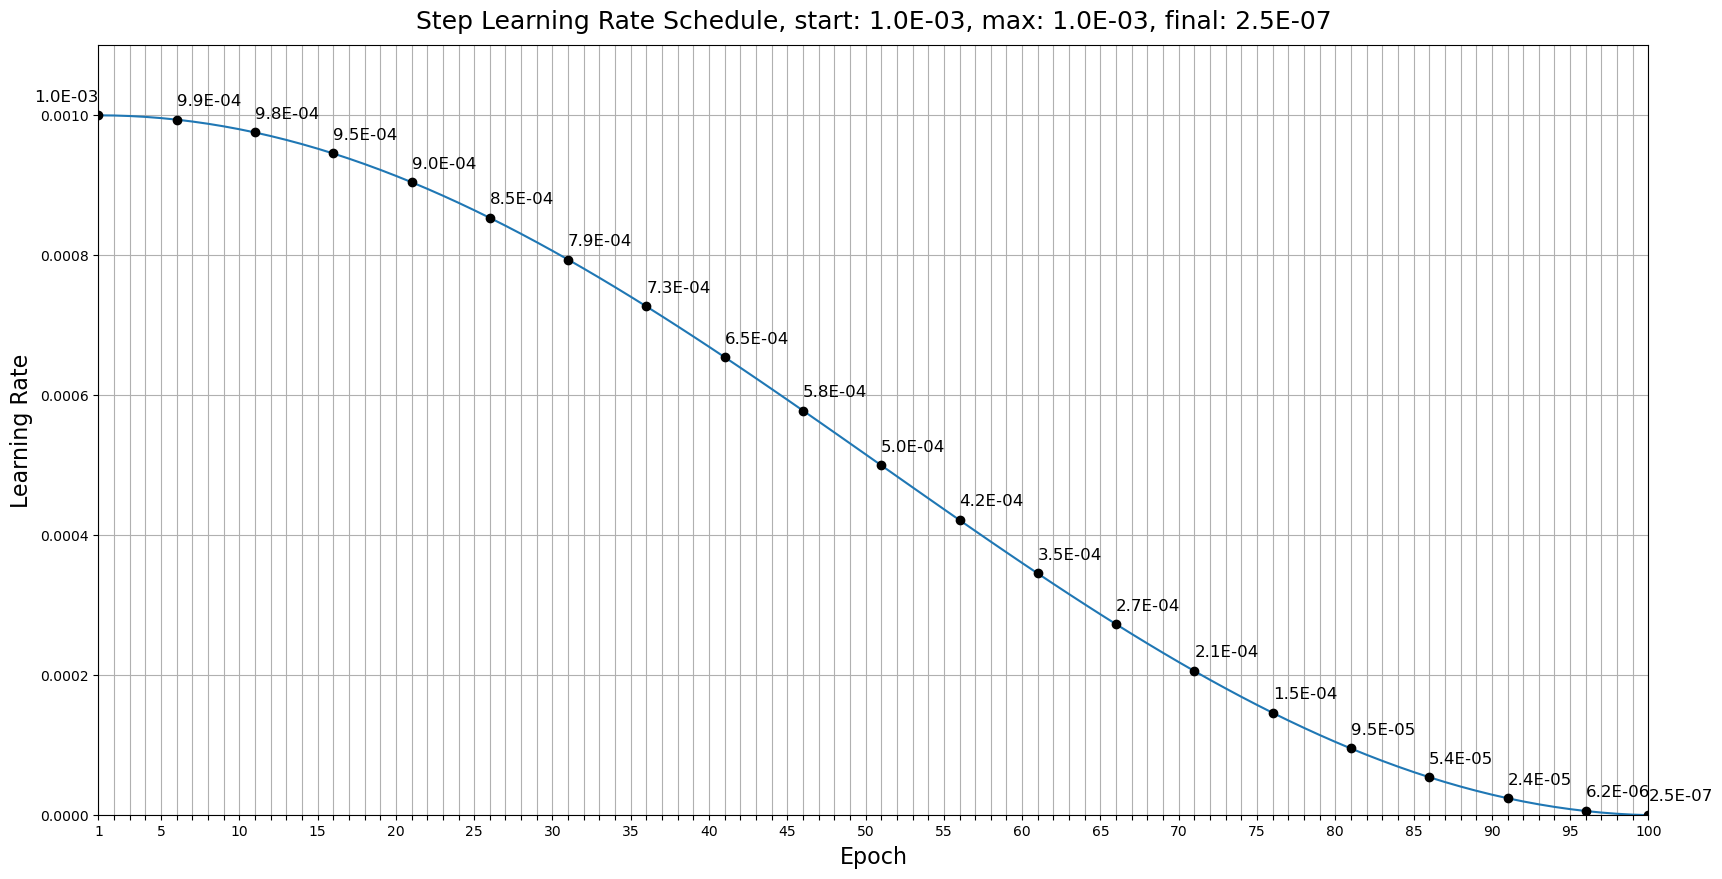

In [48]:
def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1
    
    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])
    
    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)
    
    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)
    
    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=cfg.N_WARMUP_EPOCHS, lr_max=cfg.LR_MAX, num_cycles=0.50) for step in range(cfg.N_EPOCHS)]
# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=cfg.N_EPOCHS)
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)

#### Weight decay callback

In [49]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=cfg.WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model_one.optimizer.weight_decay = model_one.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model_one.optimizer.learning_rate.numpy():.2e}, weight decay: {model_one.optimizer.weight_decay.numpy():.2e}')

In [50]:
%%timeit -n 100
if cfg.TRAIN_MODEL:
    # Verify model_one prediction is <<<100ms
    model_one.predict_on_batch({ 'frames': X[:1], 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS[:1] })

54 ns ± 5.42 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Training

In [51]:
X_train = X[train_idxs]
X_val = X[val_idxs]
NON_EMPTY_FRAME_IDXS_TRAIN = NON_EMPTY_FRAME_IDXS[train_idxs]
NON_EMPTY_FRAME_IDXS_VAL = NON_EMPTY_FRAME_IDXS[val_idxs]
y_train = y[train_idxs]
y_val = y[val_idxs]

In [52]:
# delete variables as we go to free up RAM
del X_train; del y_train

## Training

In [53]:
if cfg.TRAIN_MODEL:
    tf.keras.backend.clear_session()
    callbacks=[
            lr_callback,
            WeightDecayCallback(),
           # wandb.keras.WandbCallback()
    ]
    model_one.fit(
        x=get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS),
        steps_per_epoch=len(X) // (cfg.NUM_CLASSES * cfg.BATCH_ALL_SIGNS_N),
        epochs=cfg.N_EPOCHS,
        batch_size=cfg.BATCH_SIZE,
        callbacks=callbacks,
        verbose = 2,) 

In [54]:
# save model artifacts
if cfg.TRAIN_MODEL:# serialize weights to HDF5
    model_one.save("model_v1.1.h5")

In [55]:
# # Landmark Weights
# weights = scipy.special.softmax(model_one.get_layer('custom_embedding').weights[15])
# landmarks = ['lips_embedding', 'left_hand_embedding', 'right_hand_embedding', 'pose_embedding']

# # Learned attention weights, initialized at uniform 25%
# for w, lm in zip(weights, landmarks):
#     print(f'{lm} weight: {(w*100):.1f}%')

# Feed-Forward Neural Networks

## Configuration

In [56]:

NUM_FRAMES = 15
SEGMENTS = 3

LEFT_HAND_OFFSET = 468
POSE_OFFSET = LEFT_HAND_OFFSET+21
RIGHT_HAND_OFFSET = POSE_OFFSET+33

## average over the entire face, and the entire 'pose'
averaging_sets = [[0, 468], [POSE_OFFSET, 33]]

lip_landmarks = [61, 185, 40, 39, 37,  0, 267, 269, 270, 409,
                 291,146, 91,181, 84, 17, 314, 405, 321, 375, 
                 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 
                 95, 88, 178, 87, 14,317, 402, 318, 324, 308]
left_hand_landmarks = list(range(LEFT_HAND_OFFSET, LEFT_HAND_OFFSET+21))
right_hand_landmarks = list(range(RIGHT_HAND_OFFSET, RIGHT_HAND_OFFSET+21))
print(len(lip_landmarks))
point_landmarks = [item for sublist in [lip_landmarks, left_hand_landmarks, right_hand_landmarks] for item in sublist]
LANDMARKS = len(point_landmarks) + len(averaging_sets)
print(LANDMARKS)
if CFG.DROP_Z:
    INPUT_SHAPE = (NUM_FRAMES,LANDMARKS*2)
else:
    INPUT_SHAPE = (NUM_FRAMES,LANDMARKS*3)

FLAT_INPUT_SHAPE = (INPUT_SHAPE[0] + 2 * (SEGMENTS + 1)) * INPUT_SHAPE[1]
print(FLAT_INPUT_SHAPE)

40
84
5796


In [57]:
DROP_Z = True

NUM_FRAMES = 15
SEGMENTS = 3

LEFT_HAND_OFFSET = 468
POSE_OFFSET = LEFT_HAND_OFFSET+21
RIGHT_HAND_OFFSET = POSE_OFFSET+33

## average over the entire face, and the entire 'pose'
averaging_sets = [[0, 468], [POSE_OFFSET, 33]]

lip_landmarks = [61, 185, 40, 39, 37,  0, 267, 269, 270, 409,
                 291,146, 91,181, 84, 17, 314, 405, 321, 375, 
                 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 
                 95, 88, 178, 87, 14,317, 402, 318, 324, 308]
left_hand_landmarks = list(range(LEFT_HAND_OFFSET, LEFT_HAND_OFFSET+21))
right_hand_landmarks = list(range(RIGHT_HAND_OFFSET, RIGHT_HAND_OFFSET+21))

point_landmarks = [item for sublist in [lip_landmarks, left_hand_landmarks, right_hand_landmarks] for item in sublist]

LANDMARKS = len(point_landmarks) + len(averaging_sets)
print(LANDMARKS)
if DROP_Z:
    INPUT_SHAPE1 = (NUM_FRAMES,LANDMARKS*2)
else:
    INPUT_SHAPE1 = (NUM_FRAMES,LANDMARKS*3)

FLAT_INPUT_SHAPE = (INPUT_SHAPE1[0] + 2 * (SEGMENTS + 1)) * INPUT_SHAPE1[1]
print(FLAT_INPUT_SHAPE)

84
3864


## Utilites

In [58]:
def tf_nan_mean(x, axis=0):
    return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis) / tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis)

def tf_nan_std(x, axis=0):
    d = x - tf_nan_mean(x, axis=axis)
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis))

def flatten_means_and_stds(x, axis=0):
    # Get means and stds
    x_mean = tf_nan_mean(x, axis=0)
    x_std  = tf_nan_std(x,  axis=0)

    x_out = tf.concat([x_mean, x_std], axis=0)
    x_out = tf.reshape(x_out, (1, INPUT_SHAPE[1]*2))
    x_out = tf.where(tf.math.is_finite(x_out), x_out, tf.zeros_like(x_out))
    return x_out

In [59]:
def flatten_means_and_stds1(x, axis=0):
    # Get means and stds
    x_mean = tf_nan_mean(x, axis=0)
    x_std  = tf_nan_std(x,  axis=0)

    x_out = tf.concat([x_mean, x_std], axis=0)
    x_out = tf.reshape(x_out, (1, INPUT_SHAPE1[1]*2))
    x_out = tf.where(tf.math.is_finite(x_out), x_out, tf.zeros_like(x_out))
    return x_out

class FeatureGen_2(tf.keras.layers.Layer):
    def __init__(self):
        super(FeatureGen_2, self).__init__()
    
    def call(self, x_in):
        if DROP_Z:
            x_in = x_in[:, :, 0:2]
        x_list = [tf.expand_dims(tf_nan_mean(x_in[:, av_set[0]:av_set[0]+av_set[1], :], axis=1), axis=1) for av_set in averaging_sets]
        x_list.append(tf.gather(x_in, point_landmarks, axis=1))
        x = tf.concat(x_list, 1)

        x_padded = x
        for i in range(SEGMENTS):
            p0 = tf.where( ((tf.shape(x_padded)[0] % SEGMENTS) > 0) & ((i % 2) != 0) , 1, 0)
            p1 = tf.where( ((tf.shape(x_padded)[0] % SEGMENTS) > 0) & ((i % 2) == 0) , 1, 0)
            paddings = [[p0, p1], [0, 0], [0, 0]]
            x_padded = tf.pad(x_padded, paddings, mode="SYMMETRIC")
        x_list = tf.split(x_padded, SEGMENTS)
        x_list = [flatten_means_and_stds1(_x, axis=0) for _x in x_list]

        x_list.append(flatten_means_and_stds1(x, axis=0))
        
        ## Resize only dimension 0. Resize can't handle nan, so replace nan with that dimension's avg value to reduce impact.
        x = tf.image.resize(tf.where(tf.math.is_finite(x), x, tf_nan_mean(x, axis=0)), [NUM_FRAMES, LANDMARKS])
        x = tf.reshape(x, (1, INPUT_SHAPE1[0]*INPUT_SHAPE1[1]))
        x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
        x_list.append(x)
        x = tf.concat(x_list, axis=1)
        return x

In [60]:
class FeatureGen(tf.keras.layers.Layer):
    def __init__(self):
        super(FeatureGen, self).__init__()
    
    def call(self, x_in):
        #x_in = load_relevant_data_subset(x_in)
        if CFG.DROP_Z:
            x_in = x_in[:, :, 0:2]
        x_list = [tf.expand_dims(tf_nan_mean(x_in[:, av_set[0]:av_set[0]+av_set[1], :], axis=1), axis=1) 
                  for av_set in averaging_sets]
        x_list.append(tf.gather(x_in, point_landmarks, axis=1))
        x = tf.concat(x_list, 1)
        #avg pose+face, 82 landmarks - (23,84,3)
        x_padded = x
        for i in range(SEGMENTS):
            p0 = tf.where( ((tf.shape(x_padded)[0] % SEGMENTS) > 0) & ((i % 2) != 0) , 1, 0)
            p1 = tf.where( ((tf.shape(x_padded)[0] % SEGMENTS) > 0) & ((i % 2) == 0) , 1, 0)
            paddings = [[p0, p1], [0, 0], [0, 0]]
            x_padded = tf.pad(x_padded, paddings, mode="SYMMETRIC")
        x_list = tf.split(x_padded, SEGMENTS)
        #padding upto /3 and splitting - (24,84,3)

        #flatten (8,84,3),(8,84,3),(8,84,3) with means and std - so, we would get 3 sets
        x_list = [flatten_means_and_stds(_x, axis=0) for _x in x_list]

        #flatten (23,84,3) with means and std
        x_list.append(flatten_means_and_stds(x, axis=0))
        print(x_list)
        ## Resize only dimension 0. Resize can't handle nan, so replace nan with that dimension's avg value to reduce impact.
        #resize (23,84,3) to (15,84,3)
        x = tf.image.resize(tf.where(tf.math.is_finite(x), x, tf_nan_mean(x, axis=0)), [NUM_FRAMES, LANDMARKS])
        #flatten it
        x = tf.reshape(x, (1, INPUT_SHAPE[0]*INPUT_SHAPE[1]))
        x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
        x_list.append(x)
        x = tf.concat(x_list, axis=1)
        return x

In [61]:
#added in version 20
def normalize_data(x, axis=0):
    # Get means and stds
    x_mean = tf_nan_mean(x, axis=0)
    x_std  = tf_nan_std(x,  axis=0)
    return  (x - x_mean) / x_std

## Create dataset

In [62]:
if CFG.make_featuregen:    
    xs=[]
    ys=[]
    for i in tqdm(range(len(train))):
        path = f"{CFG.data_path}{train.iloc[i].path}"
        xs.append(FeatureGen()(load_relevant_data_subset(path)))
        ys.append(train.iloc[i].label)
    X = np.array(xs)
    y = np.array(ys)
    np.save("X_featuregen.npy", X)
    np.save("y_featuregen.npy", y)
else:
    if CFG.DROP_Z:
        X = np.load("/kaggle/input/asl-features/feature-set-one/feature_data.npy")
        y = np.load("/kaggle/input/asl-features/feature-set-one/feature_labels.npy")        
    else:
        X = np.load("/kaggle/input/islr-feature-gen-dataset/X_featuregen.npy")
        y = np.load("/kaggle/input/islr-feature-gen-dataset/y_featuregen.npy")

In [63]:
# X_norm_mean = tf_nan_mean(X, axis=0)
# X_norm_std = tf_nan_std(X,  axis=0)

# #data_leakage, split and then normalize
# X=np.array(normalize_data(X))
# X

In [64]:
# #don't use, could lead to data leakage
# class FeatureGenInf(tf.keras.layers.Layer):
#     def __init__(self, dist_mean = X_norm_mean, dist_std = X_norm_std ):
#         super(FeatureGenInf, self).__init__()
#         self.dist_mean = tf.constant(dist_mean,dtype=tf.float32)
#         self.dist_std = tf.constant(dist_std, dtype=tf.float32)
    
#     def call(self, x_in):
#         if CFG.DROP_Z:
#             x_in = x_in[:, :, 0:2]
#         x_list = [tf.expand_dims(tf_nan_mean(x_in[:, av_set[0]:av_set[0]+av_set[1], :], axis=1), axis=1) 
#                   for av_set in averaging_sets]
#         x_list.append(tf.gather(x_in, point_landmarks, axis=1))
#         x = tf.concat(x_list, 1)
#         #avg pose+face, 82 landmarks - (23,84,3)
#         x_padded = x
#         for i in range(SEGMENTS):
#             p0 = tf.where( ((tf.shape(x_padded)[0] % SEGMENTS) > 0) & ((i % 2) != 0) , 1, 0)
#             p1 = tf.where( ((tf.shape(x_padded)[0] % SEGMENTS) > 0) & ((i % 2) == 0) , 1, 0)
#             paddings = [[p0, p1], [0, 0], [0, 0]]
#             x_padded = tf.pad(x_padded, paddings, mode="SYMMETRIC")
#         x_list = tf.split(x_padded, SEGMENTS)
#         #padding upto /3 and splitting - (24,84,3)

#         #flatten (8,84,3),(8,84,3),(8,84,3) with means and std - so, we would get n/3 sets
#         x_list = [flatten_means_and_stds(_x, axis=0) for _x in x_list]

#         #flatten (23,84,3) with means and std
#         x_list.append(flatten_means_and_stds(x, axis=0))

#         ## Resize only dimension 0. Resize can't handle nan, so replace nan with that dimension's avg value to reduce impact.
#         #resize (23,84,3) to (15,84,3)
#         x = tf.image.resize(tf.where(tf.math.is_finite(x), x, tf_nan_mean(x, axis=0)), [NUM_FRAMES, LANDMARKS])
#         #flatten it
#         x = tf.reshape(x, (1, INPUT_SHAPE[0]*INPUT_SHAPE[1]))
#         x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
#         x_list.append(x)
#         x = tf.concat(x_list, axis=1)
#         x = (x - self.dist_mean) / self.dist_std
#         return x

In [65]:
# def load_xy():
#     all_x = np.load("/kaggle/input/isolated-sign-language-aggregation-preparation/feature_data.npy").astype(np.float32)
#     all_y = np.load("/kaggle/input/isolated-sign-language-aggregation-preparation/feature_labels.npy").astype(np.uint8)

#     # add nan back in not to screw up means/std
#     all_x = np.where(all_x==0.0, np.nan, all_x)

#     # Get mean and std ignoring nans
#     all_mean = np.nanmean(all_x, keepdims=True, axis=0)
#     all_std = np.nanstd(all_x, keepdims=True, axis=0)

#     all_x = (all_x-all_mean)/all_std
#     # Technically I don't need to do the were because np.nan 
#     # subtracting or dividing anything still results in np.nan
#     #    - all_x = np.where(np.isnan(all_x), all_x, all_x-all_mean)
#     #    - all_x = np.where(np.isnan(all_x), all_x, all_x/all_std)

#     # Back to 0s
#     all_x = np.nan_to_num(all_x)
#     return all_x, all_y

In [66]:
# all_x = np.load("/kaggle/input/isolated-sign-language-aggregation-preparation/feature_data.npy").astype(np.float32)
# all_y = np.load("/kaggle/input/isolated-sign-language-aggregation-preparation/feature_labels.npy").astype(np.uint8)

# # add nan back in not to screw up means/std
# all_x = np.where(all_x==0.0, np.nan, all_x)

# # Get mean and std ignoring nans
# all_mean = np.nanmean(all_x, keepdims=True, axis=0)
# all_std = np.nanstd(all_x, keepdims=True, axis=0)

# all_x = (all_x-all_mean)/all_std
# # Technically I don't need to do the were because np.nan 
# # subtracting or dividing anything still results in np.nan
# #    - all_x = np.where(np.isnan(all_x), all_x, all_x-all_mean)
# #    - all_x = np.where(np.isnan(all_x), all_x, all_x/all_std)

# # Back to 0s
# all_x = np.nan_to_num(all_x)

In [67]:
# def dumb_tf_mean(x, axis=None):
#     return tf.math.reduce_mean(x, axis=axis)

# def dumb_tf_std(x, axis=None):
#     x = tf.experimental.numpy.var(x, axis=axis, dtype=tf.float32, ddof=1)
#     return tf.experimental.numpy.sqrt(x)

# class PrepInputs(tf.keras.layers.Layer):
#     def __init__(self, lh_idx_range=(468, 489), pose_idx_range=(489, 522), rh_idx_range=(522, 543), distribution_mean=all_mean, distribution_std=all_std):
#         super(PrepInputs, self).__init__()
#         self.lips = tf.constant([61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291, 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308, 78, 95, 88, 178, 87, 14, 317, 402, 318, 324, 308])
#         self.idx_ranges = [lh_idx_range, pose_idx_range, rh_idx_range]
#         self.flat_feat_lens = [2*self.lips.shape[0],]+[2*(_range[1]-_range[0]) for _range in self.idx_ranges]
#         self.distribution_mean = tf.constant(distribution_mean, dtype=tf.float32)
#         self.distribution_std  = tf.constant(distribution_std, dtype=tf.float32)
    
#     def call(self, x_in):
        
#         # Split the single vector into 4
#         xs = [tf.gather(x_in[..., :2], self.lips, axis=1),]+[x_in[:, _range[0]:_range[1], :2] for _range in self.idx_ranges]
        
#         # Reshape based on specific number of keypoints
#         xs = [tf.reshape(_x, (-1, flat_feat_len)) for _x, flat_feat_len in zip(xs, self.flat_feat_lens)]
        
#         # Drop empty rows - Empty rows are present in 
#         #   --> face, lh, rh
#         #   --> so we don't have to for face
#         xs = [tf.boolean_mask(_x, tf.reduce_all(tf.logical_not(tf.math.is_nan(_x)), axis=1), axis=0) for _x in xs]
        
#         # Get means and stds
#         x_means = [dumb_tf_mean(_x, axis=0) for _x in xs]
#         x_stds  = [dumb_tf_std(_x,  axis=0) for _x in xs]
        
#         x_out = tf.concat([*x_means, *x_stds], axis=0)
#         x_out = tf.expand_dims(tf.where(tf.math.is_nan(x_out), tf.zeros_like(x_out), x_out), axis=0)
#         x_out = self.standardize_tensor(x_out)
#         return x_out
    
#     def standardize_tensor(self, tensor):
#         return tf.where(tensor!=0, (tensor-self.distribution_mean)/self.distribution_std, tf.zeros_like(tensor))
    
# p_demo = PrepInputs()(load_relevant_data_subset(CFG.data_path+train.path[0]))
# print(p_demo.shape)

## Models

In [68]:
def get_model_2():
    inputs = tf.keras.Input(shape=(472,), dtype=tf.float32)
    vector = tf.keras.layers.Dense(1024, activation="gelu")(inputs)
    vector = tf.keras.layers.BatchNormalization()(vector) # Batch normalization layer
    #vector = tf.keras.layers.Dropout(0.4)(vector) # Dropout layer
    vector = tf.keras.layers.Reshape((1, 1024))(vector)
    #vector - tf.keras.layers.LSTM(1024)(vector)
    vector = tf.keras.layers.Dense(512, activation="gelu")(vector)
    vector = tf.keras.layers.BatchNormalization()(vector) # Batch normalization layer
    #vector = tf.keras.layers.Dropout(0.4)(vector) # Dropout layer
    vector = tf.keras.layers.Flatten()(vector)
    output = tf.keras.layers.Dense(250, activation="softmax")(vector)

    model = tf.keras.Model(inputs=inputs, outputs=output)
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
        metrics=[
            "accuracy", 
            tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top-5-accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name="top-10-accuracy")
        ]
    )
    return model

In [69]:
def get_model_1():
    inputs = tf.keras.Input(shape=(1,5796), dtype=tf.float32)
    vector = tf.keras.layers.Dense(1024, activation="gelu")(inputs)
    vector = tf.keras.layers.BatchNormalization()(vector) # Batch normalization layer
    #vector = tf.keras.layers.Dropout(0.2)(vector) # Dropout layer
    vector = tf.keras.layers.Dense(512, activation="gelu")(vector)
    vector = tf.keras.layers.BatchNormalization()(vector) # Batch normalization layer
    #vector = tf.keras.layers.Dropout(0.2)(vector) # Dropout layer
    vector = tf.keras.layers.Flatten()(vector)
    output = tf.keras.layers.Dense(250, activation="softmax")(vector)

    model = tf.keras.Model(inputs=inputs, outputs=output)
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
        metrics=[
            "accuracy", 
            tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top-5-accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name="top-10-accuracy")
        ]
    )
    return model

In [70]:
def get_model_4():
    inputs = tf.keras.Input(shape=(3864,), dtype=tf.float32)
    vector = tf.keras.layers.Dense(2048)(inputs)
    vector = tf.keras.layers.BatchNormalization()(vector)
    vector = tf.keras.layers.Activation('gelu')(vector)
    #vector = tf.keras.layers.Dropout(0.3)(vector)

    vector = tf.keras.layers.Dense(1024)(vector)
    vector = tf.keras.layers.BatchNormalization()(vector)
    vector = tf.keras.layers.Activation('gelu')(vector)
    #vector = tf.keras.layers.Dropout(0.1)(vector)

    vector = tf.keras.layers.Dense(512)(vector)
    vector = tf.keras.layers.BatchNormalization()(vector)
    vector = tf.keras.layers.Activation('gelu')(vector)
    #vector = tf.keras.layers.Dropout(0.1)(vector)
    vector = tf.keras.layers.Flatten()(vector)
    outputs = tf.keras.layers.Dense(250, activation="softmax")(vector)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
        metrics=[
            "accuracy", 
            tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top-5-accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name="top-10-accuracy")
        ]
    )
    return model


In [71]:
# # define the K-fold cross-validation
# k = 4
# gkf = GroupKFold(n_splits=k)
# groups=train['participant_id'].values

# X_fold = np.array(X).reshape(X.shape[0],X.shape[2])
# # initialize empty lists to store the validation accuracy and best model checkpoints for each fold
# val_acc_per_fold = []
# best_model_per_fold = []

# gc.collect()
# # loop over the folds
# if CFG.kfold_training:
#     for fold, (train_idx, val_idx) in enumerate(gkf.split(all_x, all_y, groups)):
#         print(f"Fold {fold+1}...")
#         X_train, y_train = all_x[train_idx], all_y[train_idx]
#         X_val, y_val = all_x[val_idx], all_y[val_idx]

#         # define the callbacks for this fold
#         callbacks = [
#             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.97,
#                                                  patience=2, verbose=0),
#             tf.keras.callbacks.ModelCheckpoint(f"modelv0.8.1_fold_{fold}.h5", save_best_only=True, 
#                                                restore_best_weights=True, monitor="val_accuracy", 
#                                                mode="max")
#         ]

#         # create and train the model
#         model = get_model_2()
#         history = model.fit(X_train, y_train, epochs=60, validation_data=(X_val, y_val), 
#                             batch_size=1024, callbacks=callbacks)
        
#         del X_train, X_val
#         gc.collect()
#         # evaluate the model on the validation data and save the best model checkpoint
#         val_acc = np.max(history.history["val_accuracy"])
#         print(f"Val_acc_fold{fold}:{val_acc}")
#         val_acc_per_fold.append(val_acc)
#         best_model_per_fold.append(tf.keras.models.load_model(f"modelv0.8.1_fold_{fold}.h5"))
# # else:
# #     for fold in range(k):
# #         best_model_per_fold.append(tf.keras.models.load_model(f"/kaggle/input/islr-submission-models/modelv0.8_fold_{fold}.h5"))

# del all_x,all_y,X_fold
# gc.collect()

# def get_model_3():
#     inputs = tf.keras.Input(shape=(472,), dtype=tf.float32)
#     outputs = [model(inputs) for model in best_model_per_fold]
#     output = tf.keras.layers.Average()(outputs)
    
#     model = tf.keras.Model(inputs=inputs, outputs=output)
#     model.compile(
#         optimizer = tf.keras.optimizers.Adam(learning_rate=0.00033),
#         loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
#         metrics=[
#             "accuracy", 
#             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top-5-accuracy"),
#             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name="top-10-accuracy")
#         ]
#     )

#     return model

# #get_model_3().save("model_v0.8.1.h5")

## Training

In [72]:
if CFG.is_training:
    #X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=33, stratify=y)
    #print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
    #del X,y
    gc.collect()
    model = get_model_4()
#     callbacks = [
#         tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.97,
#                                               patience=2, verbose=0),
#         tf.keras.callbacks.ModelCheckpoint("model_linear57.h5", save_best_only=True, 
#                                            restore_best_weights=True, monitor="val_accuracy", 
#                                            mode="max")
#     ]
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.97,
                                              patience=2, verbose=0),
        tf.keras.callbacks.ModelCheckpoint("model_linear38.h5", save_best_only=True, 
                                           restore_best_weights=True, monitor="accuracy", 
                                           mode="max")
    ]
#     model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), 
#               batch_size=256, callbacks=callbacks)
    model.fit(X, y, epochs=120, batch_size=64, callbacks=callbacks)
#     model.fit(X, y, epochs=100, validation_data=(X_val, y_val), 
#               batch_size=256, callbacks=callbacks)
    
    # Plot the validation accuracy over each epoch
#     plt.plot(model.history.history["val_accuracy"])
#     plt.title("Validation Accuracy Over Epochs")
#     plt.xlabel("Epoch")
#     plt.ylabel("Validation Accuracy")
#     plt.show()
    
else:
    #model_0 = tf.keras.models.load_model("/kaggle/input/islr-submission-models/model_v0.2.h5")
    model_1 = tf.keras.models.load_model("/kaggle/input/islr-submission-models/model_linear57.h5")
    #model_2 = tf.keras.models.load_model("/kaggle/input/islr-submission-models/model_v0.4.2.h5")
    #model_3 = tf.keras.models.load_model("/kaggle/input/islr-submission-models/model_v0.8.1.h5")
    model_4 = tf.keras.models.load_model("/kaggle/input/islr-submission-models/model_linear38.h5")
    
    model_5 = tf.keras.models.load_model("/kaggle/input/islr-submission-models/model_v1.1.h5", 
                                         custom_objects = {'CustomEmbedding': CustomEmbedding, 
                                                           'Transformer': lambda: Transformer(num_blocks=2),
                                                           'lr': get_lr_metric})

#model_1.summary()
# model_2.summary()
#model_3.summary()
# model_4.summary()
# model_5.summary()


# Create an Inference Model
This inference Model wraps the previous trained DNN model and do following preprocessing:
* Replace nan value with 0
* calcuate mean frame of the input tensor with (None, 543, 3) shape and convert to (1, 543, 3) shape.

In [73]:
def get_inference_model(model_1, model_4, model_5):
    inputs = tf.keras.Input((543, 3), dtype=tf.float32, name="inputs")
    #x0 = tf.gather(inputs, LANDMARK_IDX, axis=1)
    #x0 = tf.where(tf.math.is_nan(x0), tf.zeros_like(x0), x0)
    #x0 = tf.reduce_mean(x0, axis=0, keepdims=True)
    x1 = FeatureGen()(inputs)
    #x2 = PrepInputs()(inputs)
    #x3 = PrepInputs()(inputs)
    x4 = FeatureGen_2()(inputs)
    x5, non_empty_frame_idxs  = PreprocessLayer()(inputs)
    
    x1 = tf.reshape(x1, (-1, 1, 5796))
    #x2 = tf.reshape(x2, (-1,472))
    #x3 = tf.reshape(x3, (-1,472))
    #x4 = tf.reshape(x4, (-1, 1, 3864))
    x5 = tf.expand_dims(x5, axis=0)
    non_empty_frame_idxs = tf.expand_dims(non_empty_frame_idxs, axis=0)
    
    x1_out = model_1(x1)[0, :]
    #x2 = model_2(x2)
    #x3 = model_3(x3)
    #x0 = model_0(x0)
    x4_out = model_4(x4)[0, :]
    x5_out = model_5({ 'frames': x5, 'non_empty_frame_idxs': non_empty_frame_idxs })
    x5_out = tf.squeeze(x5_out, axis=0)
    
    output = (0.1 * x1_out) + (0.2* x4_out) + (0.7* x5_out)
    #x = tf.keras.layers.Average()([x1,x2])
    output = tf.keras.layers.Activation(activation="linear", name="outputs")(output)
    inference_model = tf.keras.Model(inputs=inputs, outputs=output) 
    inference_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    return inference_model

In [74]:
inference_model = get_inference_model(model_1, model_4, model_5)
#inference_model.summary()

[<tf.Tensor 'feature_gen/SelectV2_16:0' shape=(1, 504) dtype=float32>, <tf.Tensor 'feature_gen/SelectV2_23:0' shape=(1, 504) dtype=float32>, <tf.Tensor 'feature_gen/SelectV2_30:0' shape=(1, 504) dtype=float32>, <tf.Tensor 'feature_gen/SelectV2_37:0' shape=(1, 504) dtype=float32>]


In [75]:
inference_model.save("ensemble_model_5796linear+3864Linear+Transformer.h5")

# Create submission file
Unlike a csv file in our previous competitions, the submission file has to be a compressed tflite file with name submissiom.zip.

In [76]:
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] #great line
tflite_model = converter.convert()
model_path = "ensemble_model_5796linear+3864Linear+Transformer.tflite"
# Save the model.
with open(model_path, 'wb') as f:
    f.write(tflite_model)
os.path.getsize("ensemble_model_5796linear+3864Linear+Transformer.tflite")

[<tf.Tensor 'model_1/feature_gen/SelectV2_16:0' shape=(1, 504) dtype=float32>, <tf.Tensor 'model_1/feature_gen/SelectV2_23:0' shape=(1, 504) dtype=float32>, <tf.Tensor 'model_1/feature_gen/SelectV2_30:0' shape=(1, 504) dtype=float32>, <tf.Tensor 'model_1/feature_gen/SelectV2_37:0' shape=(1, 504) dtype=float32>]
[<tf.Tensor 'SelectV2_16:0' shape=(1, 504) dtype=float32>, <tf.Tensor 'SelectV2_23:0' shape=(1, 504) dtype=float32>, <tf.Tensor 'SelectV2_30:0' shape=(1, 504) dtype=float32>, <tf.Tensor 'SelectV2_37:0' shape=(1, 504) dtype=float32>]
[<tf.Tensor 'SelectV2_16:0' shape=(1, 504) dtype=float32>, <tf.Tensor 'SelectV2_23:0' shape=(1, 504) dtype=float32>, <tf.Tensor 'SelectV2_30:0' shape=(1, 504) dtype=float32>, <tf.Tensor 'SelectV2_37:0' shape=(1, 504) dtype=float32>]


20996888

In [77]:
!zip submission.zip $model_path

  adding: ensemble_model_5796linear+3864Linear+Transformer.tflite (deflated 61%)


# Making inferences
Let's make inferences using TFLite interpreter, our submission file will be used to make inference like following ways. To test inference speed, I will make inferences with 10000 samples.

In [78]:
!pip install tflite-runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.7 MB/s eta 0:00:00


In [79]:
import tflite_runtime.interpreter as tflite
interpreter = tflite.Interpreter(model_path)
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")
for i in tqdm(range(1000)):
    frames = load_relevant_data_subset(f'/kaggle/input/asl-signs/{train.iloc[i].path}')
    output = prediction_fn(inputs=frames)
    sign = np.argmax(output["outputs"])
    if i % 100 == 0:
        print(f"Predicted label: {index_label[sign]}, Actual Label: {train.iloc[i].sign}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Predicted label: blow, Actual Label: blow
Predicted label: dryer, Actual Label: dryer
Predicted label: down, Actual Label: down
Predicted label: underwear, Actual Label: underwear
Predicted label: apple, Actual Label: apple
Predicted label: cow, Actual Label: cow
Predicted label: lips, Actual Label: lips
Predicted label: no, Actual Label: no
Predicted label: all, Actual Label: all
Predicted label: wait, Actual Label: wait
